In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-05-16 12:26:57.814279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return time, series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
steps_ahead = 10
time, series = generate_time_series(10000, n_steps + steps_ahead)

In [4]:
time.shape, series.shape

((60,), (10000, 60, 1))

In [5]:
# 7k/10k for training set
X_train, y_train = series[:7000, :n_steps], series[:7000, -steps_ahead:, 0]

# Next 2k/10k for validation set
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -steps_ahead:, 0]

# Next 1k/10k for test set
X_test, y_test = series[9000:, :n_steps], series[9000:, -steps_ahead:, 0]

In [10]:
# Contains 7k items having 50 training data points each, and 10 expected predictions
print("Train ", X_train.shape, y_train.shape) 

# Contains 2k items having 50 test data points each, and 10 expected predictions
print("Valid ", X_valid.shape, y_valid.shape)

# Contains 1k items having 50 validation data points each, and 10 expected predictions
print("Test ", X_test.shape, y_test.shape)

Train  (7000, 50, 1) (7000, 10)
Valid  (2000, 50, 1) (2000, 10)
Test  (1000, 50, 1) (1000, 10)


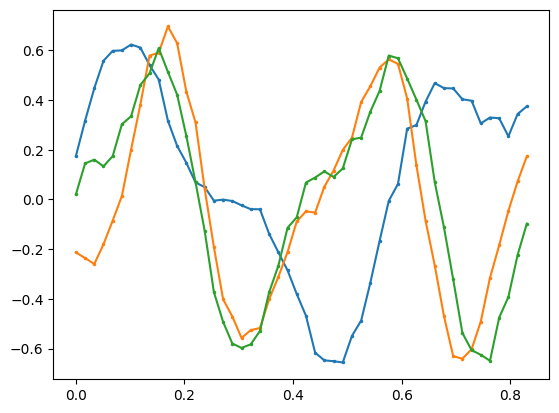

In [11]:
# There are 7K TS data, plotting only 3 of them
plt.plot(time[:n_steps], X_train[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[2, :, 0], marker='.', markersize=3)

### RNN with 3 layers of 20 cells and outputs 20 TS data

In [9]:
# sequence-to-vector RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(steps_ahead)
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30)

Epoch 1/30


2023-05-13 23:21:21.711879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


219/219 [==============================] - 3s 9ms/step - loss: 0.0531 - accuracy: 0.3940
Epoch 2/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0206 - accuracy: 0.5473
Epoch 3/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0167 - accuracy: 0.5723
Epoch 4/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0145 - accuracy: 0.5957
Epoch 5/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0131 - accuracy: 0.6081
Epoch 6/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0126 - accuracy: 0.6159
Epoch 7/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0119 - accuracy: 0.6253
Epoch 8/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0116 - accuracy: 0.6283
Epoch 9/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0109 - accuracy: 0.6321
Epoch 10/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0109 - accuracy: 0.6366
Epoch 1

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [10]:
y3 = model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [11]:
print(y3.shape)
y3[0], y3[1]

(1000, 10)


(array([-0.4945989 , -0.596012  , -0.6689208 , -0.61637455, -0.5486288 ,
        -0.3801954 , -0.21760684, -0.03798659,  0.09563921,  0.20384428],
       dtype=float32),
 array([-0.28290996, -0.31851625, -0.3361641 , -0.38409495, -0.3854253 ,
        -0.41514271, -0.34578922, -0.24349454, -0.08549523,  0.04535614],
       dtype=float32))

In [12]:
# correct way to extract first column

y3[:].shape, y_test.shape, X_train[0, :, 0].shape

((1000, 10), (1000, 10), (50,))

In [13]:
np.mean(keras.losses.mean_squared_error(y_test, y3[:, [0]]))

0.21074452

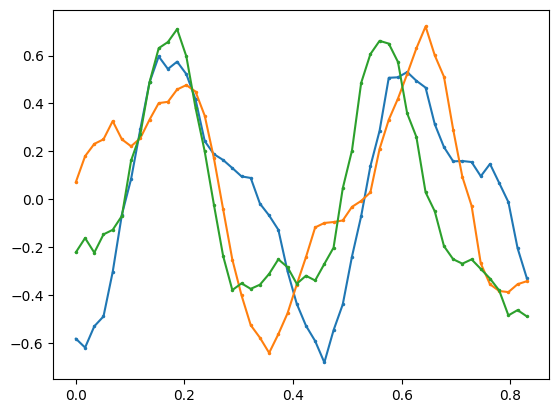

In [15]:
X_train[0, :, 0].shape, X_test[0, :, 0].shape
plt.plot(time[:n_steps], X_test[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_test[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_test[2, :, 0], marker='.', markersize=3)

In [16]:
#print(X_test[:, :, 0].shape, y3.shape)
res = np.append(X_test[:, :, 0], y3, axis=1)

def plotItem(item):
    res[item].shape, len(res[item]) , X_test[item, :, 0].shape, len(X_test[item, :, 0])
    line_space = np.linspace(0, 1, 60)
    plt.plot(line_space[:50], res[item][:50], marker='.', markersize=3)
    plt.plot(line_space[49:], res[item][49:], marker='*', markersize=3)

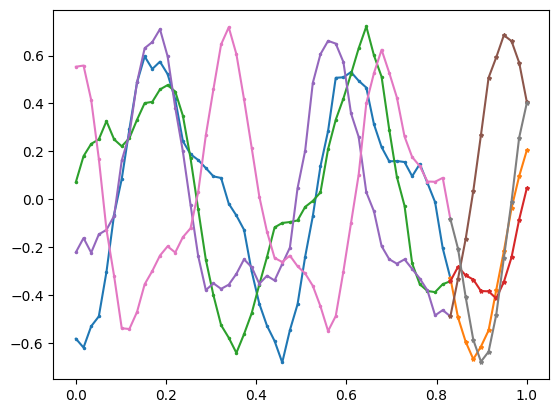

In [17]:
plotItem(0)
plotItem(1)
plotItem(2)
plotItem(3)

In [21]:
#sequence-to-sequence RNN
# Need to handle differently


Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors 

for step_ahead in range(1, 10 + 1):
    Y[:, :, steps_ahead - 1] = series[:, steps_ahead:steps_ahead + n_steps, 0]

y_train = Y[:7000]
y_valid = Y[7000:9000]
y_test = Y[9000:]

y_train.shape, y_valid.shape

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(steps_ahead))
])


optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30)

Epoch 1/30


/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


219/219 [==============================] - 3s 9ms/step - loss: 0.0089 - accuracy: 0.4325
Epoch 2/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0060 - accuracy: 0.4579
Epoch 3/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0053 - accuracy: 0.4785
Epoch 4/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0050 - accuracy: 0.4829
Epoch 5/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0048 - accuracy: 0.4838
Epoch 6/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0048 - accuracy: 0.4800
Epoch 7/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0047 - accuracy: 0.4736
Epoch 8/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0045 - accuracy: 0.4790
Epoch 9/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0045 - accuracy: 0.4808
Epoch 10/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.4863
Epoch 11/

In [23]:
y4 = model.predict(X_test)

res = np.append(X_test[:, :, 0], y4[:, :, 0], axis=1)

def plotItem(item):
    res[item].shape, len(res[item]) , X_test[item, :, 0].shape, len(X_test[item, :, 0])
    line_space = np.linspace(0, 1, 60)
    plt.plot(line_space[:50], res[item][:50], marker='.', markersize=3)
    plt.plot(line_space[49:], res[item][49:], marker='*', markersize=3)

32/32 [==============================] - 0s 3ms/step


ValueError: x and y must have same first dimension, but have shapes (11,) and (51,)

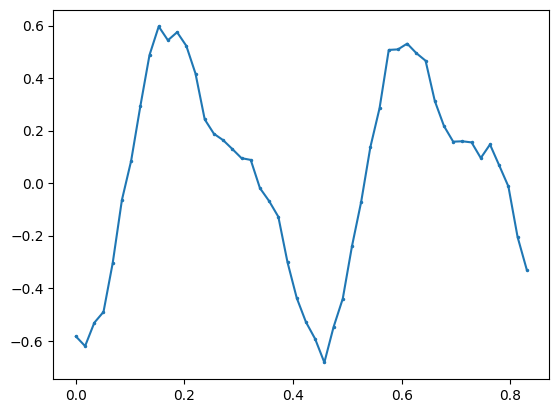

In [24]:
plotItem(0)
plotItem(1)